In [1]:

from scipy.stats import mode
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import seaborn as sb
import random as rand
from sklearn.model_selection import train_test_split
iris = load_iris()
X = iris.data

In [2]:
# convert numpy array to DataFrame
import pandas as pd
Y = pd.DataFrame(X, columns = ['Sepal Length','Sepal Width','Petal Length','Petal Width'])
Y.head()

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
all_vals = Y.values.tolist()

## K Means

In [4]:
def random_centroids(all_vals, K):    
    centroids = []
    #Place K centroids at random locations
    for i in range(K):
        centroid = all_vals[rand.randint(0, 149)]
        centroids.append(centroid)
    return centroids

In [5]:
def assign_cluster(all_vals, centroids):
    assignments = []

    for data_point in all_vals:
        dist_point_clust = []

        for centroid in centroids:
            d_clust = np.linalg.norm(np.array(data_point) - np.array(centroid))
            dist_point_clust.append(d_clust)
        
        assignment = np.argmin(dist_point_clust)
        assignments.append(assignment)

    return assignments

In [6]:
def new_centroids(all_vals, centroids, assignments, K):
    new_centroids = []
    for i in range(K):
        pt_cluster = []
        for x in range(len(all_vals)):
                if (assignments[x] == i):
                    pt_cluster.append(all_vals[x])
        mean_c = np.mean(pt_cluster, axis=0)
        new_centroids.append(mean_c)

    return new_centroids

In [7]:
def sse(all_vals, assignments, centroids):
    errors = []
    
    for i in range(len(all_vals)):
        #get assigned centroid for each point
        centroid = centroids[assignments[i]]
    
        #compute the distance (error) between one point and its closest centroid
        error = np.linalg.norm(np.array(all_vals[i]) - np.array(centroid))
        
        #append squared error to the list of error
        errors.append(error**2)
        
    #and sum up all the errors
    sse = sum(errors)
    
    return sse

In [8]:
def KMeans(all_vals,K,max_iter = 100, tol = pow(10,-3) ):
    it = -1
    all_sse = []
    assignments = []
    
    #Place K centroids at random locations
    centroids = random_centroids(all_vals, K)

   
    #Until algorithm converges
    while (len(all_sse)<=1 or (it < max_iter and np.absolute(all_sse[it] - all_sse[it-1])/all_sse[it-1] >= tol)):
        it += 1
        #Assign all data points to the closest center
        assignments = assign_cluster(all_vals, centroids)
        
        #Compute the new centroids
        centroids = new_centroids(all_vals, centroids, assignments, K)
        
        #Compute SSE
        sse_kmeans = sse(all_vals, assignments, centroids)
        all_sse.append(sse_kmeans)        
        
     
    return (assignments, centroids, all_sse, it)

In [9]:
import random as rand
result = KMeans(all_vals,K=3)

In [10]:
centroids_x = [result[1][x][0] for x in range(len(result[1]))] #sepal_length: [0] 
centroids_y = [result[1][x][2] for x in range(len(result[1]))] #petal_length: [2]

In [11]:
print(centroids_x)
print(centroids_y)

[5.88360655737705, 5.005999999999999, 6.853846153846153]
[4.388524590163935, 1.4620000000000002, 5.715384615384615]


In [12]:
x = Y['Sepal Length']
y = Y['Petal Length']
assignments = result[0]

Text(0, 0.5, 'petal_length')

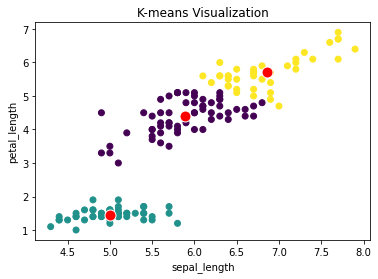

In [13]:
plt.scatter(x, y, c=assignments)
plt.plot(centroids_x,centroids_y, c='white', marker='.', linewidth='0.01', markerfacecolor='red', markersize=22)

plt.title("K-means Visualization")
plt.xlabel("sepal_length")
plt.ylabel("petal_length")

## Gaussian Mixture Model

In [14]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)
from sklearn.cluster import KMeans

In [15]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [16]:
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans(n_clusters).fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

In [17]:
def expectation_step(X, clusters):
    global gamma_nk, totals
    N = X.shape[0]
    K = len(clusters)
    totals = np.zeros((N, 1), dtype=np.float64)
    gamma_nk = np.zeros((N, K), dtype=np.float64)
    
    for k, cluster in enumerate(clusters):
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
    
        gamma_nk[:, k] = (pi_k * gaussian(X, mu_k, cov_k)).ravel()
    
    totals = np.sum(gamma_nk, 1)
    gamma_nk /= np.expand_dims(totals, 1)

In [18]:
def maximization_step(X, clusters):
    global gamma_nk
    N = float(X.shape[0])
  
    for k, cluster in enumerate(clusters):
        gamma_k = np.expand_dims(gamma_nk[:, k], 1)
        N_k = np.sum(gamma_k, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_k * X, axis=0) / N_k
        cov_k = (gamma_k * (X - mu_k)).T @ (X - mu_k) / N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

In [19]:
def get_likelihood(X, clusters):
    global gamma_nk, totals
    sample_likelihoods = np.log(totals)
    return np.sum(sample_likelihoods), sample_likelihoods

In [20]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)

    scores = np.log(gamma_nk)
    
    return clusters, likelihoods, scores, sample_likelihoods, history

### Train model

In [21]:
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -727.7880991223876
Epoch:  2 Likelihood:  -229.3310206629975
Epoch:  3 Likelihood:  -199.74812877963763
Epoch:  4 Likelihood:  -195.73888520322583
Epoch:  5 Likelihood:  -192.39610102342954
Epoch:  6 Likelihood:  -189.9948025598058
Epoch:  7 Likelihood:  -188.36696982597576
Epoch:  8 Likelihood:  -187.12218440393465
Epoch:  9 Likelihood:  -185.96888273961312
Epoch:  10 Likelihood:  -184.90274085547034
Epoch:  11 Likelihood:  -183.96159641602344
Epoch:  12 Likelihood:  -183.1229996094662
Epoch:  13 Likelihood:  -182.42175149358576
Epoch:  14 Likelihood:  -181.85314289768115
Epoch:  15 Likelihood:  -181.27453302608748
Epoch:  16 Likelihood:  -180.67059402382148
Epoch:  17 Likelihood:  -180.34032123839054
Epoch:  18 Likelihood:  -180.23332341934025
Epoch:  19 Likelihood:  -180.20041209371257
Epoch:  20 Likelihood:  -180.19017245247898
Epoch:  21 Likelihood:  -180.18696259547227
Epoch:  22 Likelihood:  -180.18594920021093
Epoch:  23 Likelihood:  -180.1856275629949
Ep

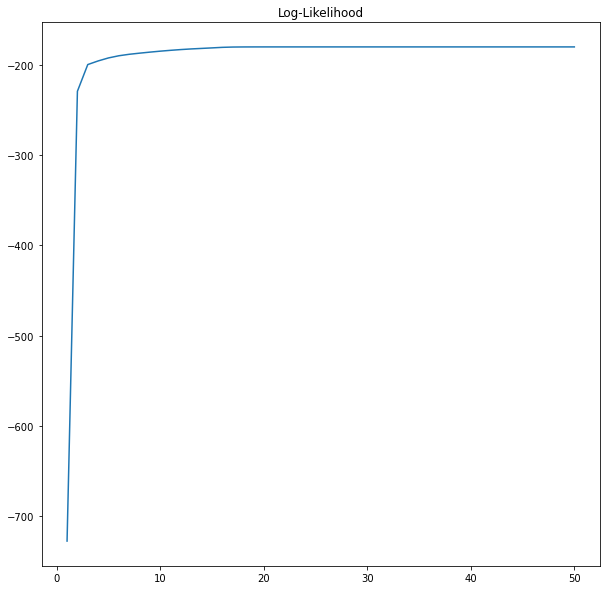

In [22]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

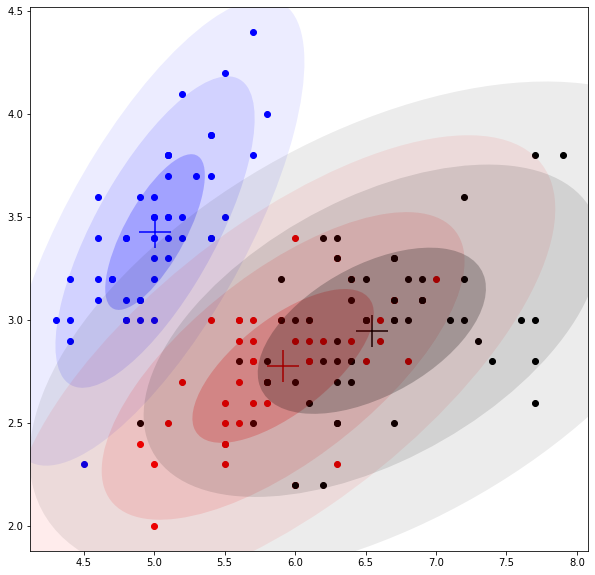

In [23]:
import matplotlib.colors as colors
from matplotlib.patches import Ellipse
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
from PIL import Image
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

In [24]:
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by our implementation:
 [[5.006      3.428      1.462      0.246     ]
 [5.91496959 2.77784365 4.20155323 1.29696685]
 [6.54454865 2.94866115 5.47955343 1.98460495]]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]
